In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [2]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a ""flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found ""passed out"" in bed, and when awoken appeared ...","neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,"
1,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, chest pain, respiratory insufficiency, acuities, ventricular wall motion study at rest, laparoscopic cholecystectomy, endotracheal intubated spect, accuities, stapler at rest and without contrast, acudal posi..."
2,"This is a 66-year-old male with signs and symptoms of benign prostatic hypertrophy, who has had recurrent urinary retention since his kidney transplant. He passed his fill and pull study and was thought to self-catheterize in the event that he does i...",Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY OF PRESENT ILLNESS: , This is a 66-year-old gentleman status post deceased donor kidney transplant in 12/07, who has had recurrent urinary retention issues since that time. Most recently, he was hospitali...","urology, urinary retention issues, cystoscopy, nephrolithiasis, kidney transplant, renal insufficiency, renal disease, renal retention, renal failure, renal transplant, kidney cancer, renal, bladder, bladder and spleen, bladder neck fistula placements..."


All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [4]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


In [5]:
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)

Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

In [6]:
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)


In [7]:

df["medical_specialty"].value_counts()

Surgery                          1242
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
Internal Medicine                 190
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Emergency & Critical Care         137
Discharge Summary                 108
ENT - Otolaryngology               98
Ophthalmology                      83
Rehab & Psychology                 74
Pediatrics - Neonatal              70
Office Notes                       51
Podiatry                           47
Dermatology                        29
Dentistry                          27
Letters                            23
Sleep Medicine                     20
IME-QME-Work Comp etc.             16
Chiropractic                       14
Rheumatology

In [8]:
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')


In [9]:
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)

Surgery                          1242
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
others                            285
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
Internal Medicine                 190
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Emergency & Critical Care         137
Discharge Summary                 108
ENT - Otolaryngology               98
Ophthalmology                      83
Rehab & Psychology                 74
Pediatrics - Neonatal              70
Name: medical_specialty, dtype: int64


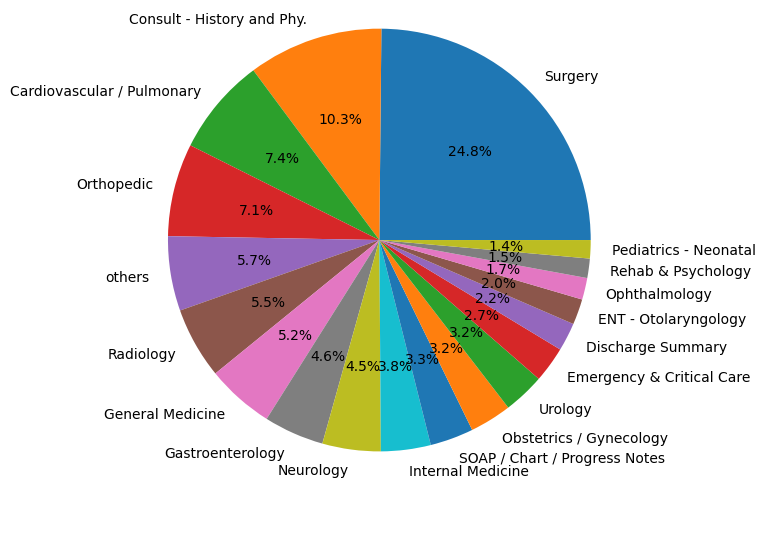

In [10]:
plt.figure(figsize=(6,6))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal');

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [12]:
df["medical_specialty"].value_counts()

Surgery                          1242
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
others                            285
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
Internal Medicine                 190
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Emergency & Critical Care         137
Discharge Summary                 108
ENT - Otolaryngology               98
Ophthalmology                      83
Rehab & Psychology                 74
Pediatrics - Neonatal              70
Name: medical_specialty, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [14]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4966 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


In [15]:
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))

Text with the minimum word count (1 words):
INDICATIONS:,

Text with the maximum word count (3029 words):
DATE OF INJURY : October 4, 2000,DATE OF EXAMINATION : September 5, 2003,EXAMINING PHYSICIAN : X Y, MD,Prior to the beginning of the examination, it is explained to the examinee that this examination is intended for evaluative purposes only, and that it is not intended to constitute a general medical examination. It is explained to the examinee that the traditional doctor-patient relationship does not apply to this examination, and that a written report will be provided to the agency requesting this examination. It has also been emphasized to the examinee that he should not attempt any physical activity beyond his tolerance, in order to avoid injury.,CHIEF COMPLAINT:  ,Aching and mid back pain.,HISTORY OF PRESENT INJURY: , Based upon the examinee's perspective: ,Mr. Abc is a 52-year-old self-employed, independent consultant for DEMILEE-USA. He is also a mechanical engineer. He repo

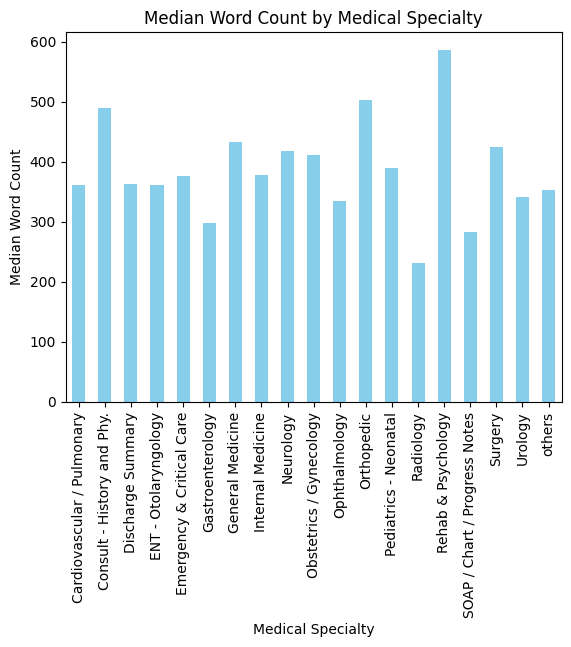

In [16]:
import matplotlib.pyplot as plt

# Add a new column 'word_count' to store the word count for each row
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Calculate the median word count for each category
average_word_count_by_category = df.groupby('medical_specialty')['word_count'].median()

# Plotting the bar chart
average_word_count_by_category.plot(kind='bar', color='skyblue')
plt.title('Median Word Count by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Median Word Count')
plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataframe
# df = pd.read_csv('first_100_rows.csv')

# Fill missing values with empty string
# df['transcription'].fillna('', inplace=True)

# Or drop rows with NaN in transcription column
# df.dropna(subset=['transcription'], inplace=True)

X = df['transcription']
y = df['medical_specialty']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# 1. Hyperparameter Tuning for Naive Bayes
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
nb = MultinomialNB()
grid_search = GridSearchCV(nb, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_nb = MultinomialNB(alpha=best_alpha)
best_nb.fit(X_train, y_train)

# 2. Ensemble Method - Random Forest
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy: %.2f%%" % (accuracy_rf * 100))

# 3. Explore Other Model - SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy: %.2f%%" % (accuracy_svm * 100))

# 4. Cross-Validation for Naive Bayes
cross_val_scores = cross_val_score(best_nb, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Mean Accuracy for Naive Bayes: %.2f%%" % (cross_val_scores.mean() * 100))

# 5. Final Evaluation of Best Model (Naive Bayes)
y_pred_best_nb = best_nb.predict(X_test)
accuracy_best_nb = accuracy_score(y_test, y_pred_best_nb)
print("Final Accuracy for Best Naive Bayes Model: %.2f%%" % (accuracy_best_nb * 100))


Random Forest Accuracy: 12.98%
SVM Accuracy: 17.71%
Cross-Validation Mean Accuracy for Naive Bayes: 34.37%
Final Accuracy for Best Naive Bayes Model: 36.52%
